## **HEART FAILURE PREDICTION**

### **Context**
`Cardiovascular diseases `(CVDs) remain the leading cause of death globally, accounting for an estimated 17.9 million deaths annually, or 31% of all global mortality. The majority of these deaths — about `4 in every 5` — are due to heart attacks and strokes, with one-third occurring prematurely in individuals under the age of 70. These conditions arise due to complex interactions among genetic, behavioral, and physiological risk factors.

The early detection and prediction of heart disease — a major category within CVDs — can be significantly improved by analyzing key clinical and lifestyle-related indicators. 

### **Attribute Information**

1. Age: age of the patient [years]
2. Sex: sex of the patient [M: Male, F: Female]
3. ChestPainType: chest pain type [TA: Typical Angina, ATA: Atypical Angina, NAP: Non-Anginal Pain, ASY: Asymptomatic]
4. RestingBP: resting blood pressure [mm Hg]
5. holesterol: serum cholesterol [mm/dl]
6. FastingBS: fasting blood sugar [1: if FastingBS > 120 mg/dl, 0: otherwise]
7. RestingECG: resting electrocardiogram results [Normal: Normal, ST: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV), LVH: showing probable or definite left ventricular hypertrophy by Estes' criteria]
   
8. MaxHR: maximum heart rate achieved [Numeric value between 60 and 202]
9.  ExerciseAngina: exercise-induced angina [Y: Yes, N: No]
10. ldpeak: oldpeak = ST [Numeric value measured in depression]
11. ST_Slope: the slope of the peak exercise ST segment [Up: upsloping, Flat: flat, Down: downsloping]
12. Target Variable: HeartDisease: output class [1: heart disease, 0: Normal]

**`Libraries`**

In [12]:
import warnings

import plotly.express as px
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from category_encoders import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.utils.validation import check_is_fitted

warnings.simplefilter(action="ignore", category=FutureWarning)

### **Prepare Data**

`Wrangle Fucntion`

In [13]:
def wrangle_data(filepath):
    # Load the dataset
    df = pd.read_csv('data/heart.csv')
    

    # Drop potentially leaky features
    df = df.drop(['Oldpeak', 'ST_Slope'], axis=1)

    # Remove outliers
    
    df = df[
    (df['Age'] >= 35) &
    (df['Cholesterol'] >= 100) & (df['Cholesterol'] <= 400) &
    (df['MaxHR'] >= 90) & (df['MaxHR'] <= 180) &
    (df['RestingBP'] >= 90) & (df['RestingBP'] <= 175)
]

    # Clean the data
    df.dropna(inplace=True)
    
    
    return df

In [14]:
df = wrangle_data('data/heart.csv')
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0
1,49,F,NAP,160,180,0,Normal,156,N,1
2,37,M,ATA,130,283,0,ST,98,N,0
3,48,F,ASY,138,214,0,Normal,108,Y,1
4,54,M,NAP,150,195,0,Normal,122,N,0


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 667 entries, 0 to 917
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Age             667 non-null    int64 
 1   Sex             667 non-null    object
 2   ChestPainType   667 non-null    object
 3   RestingBP       667 non-null    int64 
 4   Cholesterol     667 non-null    int64 
 5   FastingBS       667 non-null    int64 
 6   RestingECG      667 non-null    object
 7   MaxHR           667 non-null    int64 
 8   ExerciseAngina  667 non-null    object
 9   HeartDisease    667 non-null    int64 
dtypes: int64(6), object(4)
memory usage: 57.3+ KB


In [16]:
print(df["HeartDisease"].value_counts())

HeartDisease
0    342
1    325
Name: count, dtype: int64


### **`Explore`**

Check for  multicollinearity 

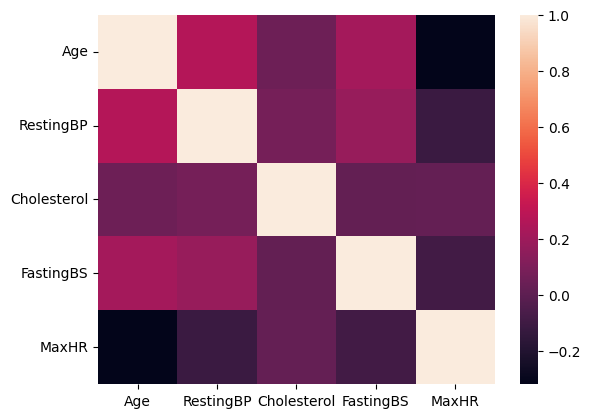

In [17]:
# Create correlation matrix
correlation = df.select_dtypes("number").drop(columns = "HeartDisease").corr()

# Plot heatmap of `correlation`
sns.heatmap(correlation);


Check for outliers

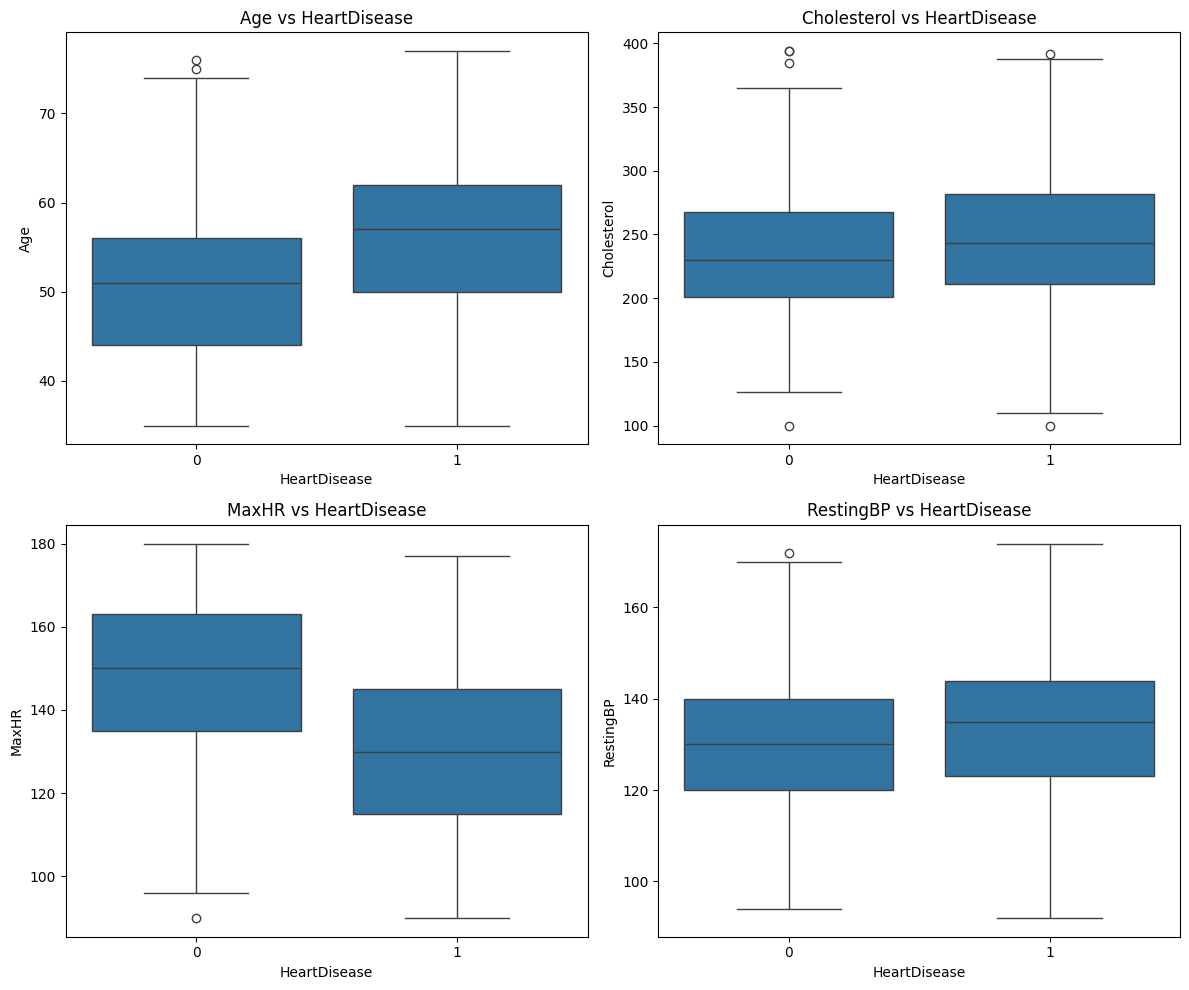

In [18]:
# Variables to plot
variables = ["Age", "Cholesterol",  "MaxHR", "RestingBP"]

# Create subplots with 2 x 2 grid
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))

# Flatten axes to make iteration easier
axes = axes.flatten()

# If axes is a 1D array, loop normally
for i, var in enumerate(variables):
    sns.boxplot(data = df, x = "HeartDisease", y = var, ax = axes[i])
    axes[i].set_title(f'{var} vs HeartDisease')
    axes[i].set_xlabel('HeartDisease')
    axes[i].set_ylabel(var)

plt.tight_layout()
plt.show()


Pivot Table

In [19]:
df["HeartDisease"].value_counts(normalize = True)

HeartDisease
0    0.512744
1    0.487256
Name: proportion, dtype: float64

In [20]:
majority_class_prop, minority_class_prop = df["HeartDisease"].value_counts(normalize = True)
print(majority_class_prop, minority_class_prop)

0.512743628185907 0.487256371814093


In [21]:
chestpain_pivot = pd.pivot_table(df, index = "ChestPainType", 
    values = "HeartDisease", aggfunc = np.mean).sort_values(by = "HeartDisease")
chestpain_pivot

,HeartDisease
ChestPainType,
ATA,0.124138
NAP,0.282051
TA,0.382353
ASY,0.753012


Plot bar chart

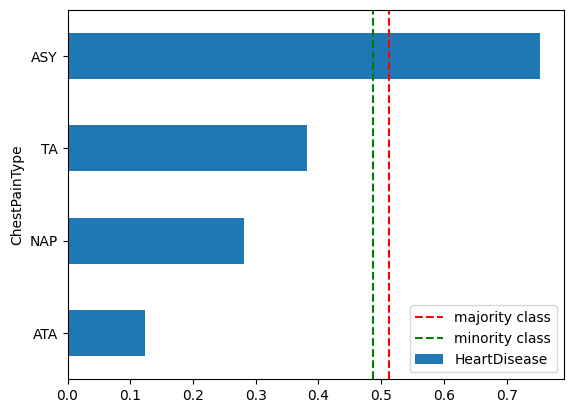

In [22]:
chestpain_pivot.plot(kind = "barh", legend = None)
plt.axvline(majority_class_prop, linestyle = "--", color = "red", label = "majority class")
plt.axvline(minority_class_prop, linestyle = "--", color = "green", label = "minority class")
plt.legend(loc = "lower right");

**`Split`**

In [23]:
target = "HeartDisease"
X = df.drop(columns = target)
y = df[target]

Perform a randomized train-test split using scikit-learn.

In [24]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.2, random_state = 42
)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (533, 9)
y_train shape: (533,)
X_test shape: (134, 9)
y_test shape: (134,)


###  **`Build Model`**

Baseline accuracy score

In [25]:
acc_baseline = y_train.value_counts(normalize = True).max()
print("Baseline Accuracy:", round(acc_baseline, 2))

Baseline Accuracy: 0.51


**`Iterate`**

Build model

In [26]:
model = make_pipeline(
    OneHotEncoder(use_cat_names = True),
    LogisticRegression(max_iter = 1000)
)

 Fit model to training data

In [27]:
model.fit(X_train, y_train)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['Sex', 'ChestPainType', 'RestingECG',
                                     'ExerciseAngina'],
                               use_cat_names=True)),
                ('logisticregression', LogisticRegression(max_iter=1000))])

### **`Evaluate`**

In [28]:
acc_train = accuracy_score(y_train, model.predict(X_train))
acc_test = model.score(X_test, y_test)

print("Training Accuracy:", round(acc_train, 2))
print("Test Accuracy:", round(acc_test, 2))

Training Accuracy: 0.82
Test Accuracy: 0.8


### **`Communicate`**

Probability estimates 

In [29]:
y_train_pred_proba = model.predict_proba(X_train)
print(y_train_pred_proba[:5])

[[0.08623356 0.91376644]
 [0.47883684 0.52116316]
 [0.07439522 0.92560478]
 [0.43305474 0.56694526]
 [0.76648247 0.23351753]]


Extract the feature names and importances from the model

In [30]:
features = model.named_steps["onehotencoder"].get_feature_names()
importances = model.named_steps["logisticregression"].coef_[0]

A pandas Series named `odds_ratios`, where the index is `features` and the values are your the exponential of the `importances`

In [31]:
odds_ratios = pd.Series(np.exp(importances), index = features).sort_values()
odds_ratios.head()

ExerciseAngina_N     0.428436
ChestPainType_ATA    0.454174
Sex_F                0.478163
RestingECG_ST        0.858530
ChestPainType_NAP    0.866976
dtype: float64

Horizontal bar chart, largest coefficients

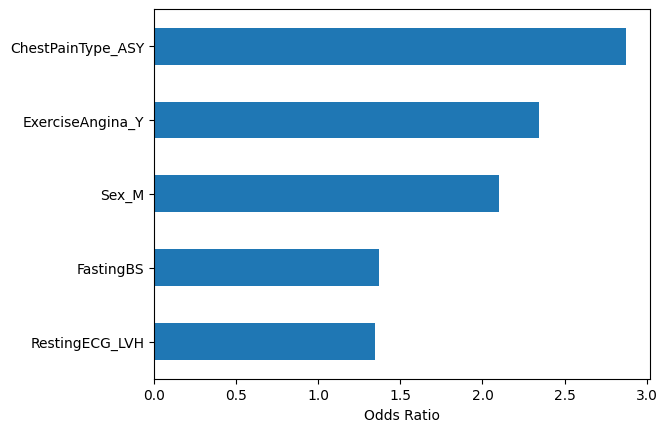

In [27]:
odds_ratios.tail().plot(kind = "barh")
plt.xlabel("Odds Ratio");

Horizontal bar chart, smallest coefficients

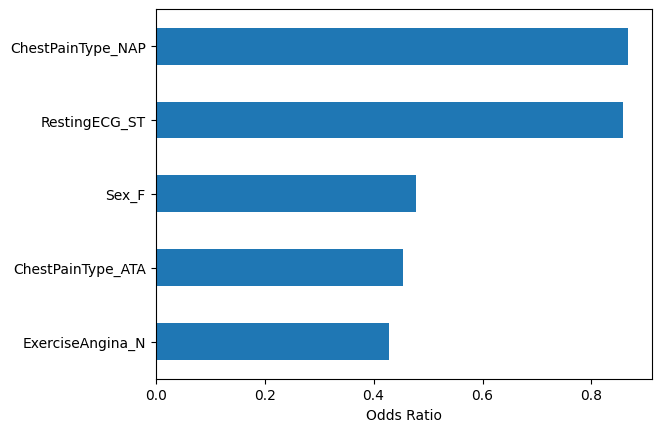

In [28]:
odds_ratios.head().plot(kind = "barh")
plt.xlabel("Odds Ratio");